### Predict Type 2 diabetes with genes with top PCA loading
by SVM, RandomForest, XGB, Keras and model ensemble

In [27]:
# this is an early version of sklearn, some names may have changed in later versions
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn import cross_validation as cv
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 


In [71]:
### Read in data
df = pd.read_csv('../results/top500pcaGene.csv')

In [3]:
df.head(3)

,t2d,3822,35766,3285,1160,1923,3296,3260,8198,3302,...,16146,11922,9406,5287,659,20372,16013,1129,3503,7459
0,0,0.000000,0.000000,0.000000,3.322937,10.815594,4.808866,7.037647,0.0,4.109481,...,0.0,5.075939,4.855219,1.789240,0.0,0.0,4.891742,5.580920,2.386135,0.000000
1,0,0.000000,3.400627,0.000000,2.284452,11.641512,5.379671,7.540405,0.0,5.365140,...,0.0,2.405160,3.903509,3.277050,0.0,0.0,0.000000,4.254837,0.000000,5.214127
2,0,3.492573,2.642864,4.768249,2.348791,10.814974,5.679429,8.156457,0.0,4.753775,...,0.0,4.323108,4.587719,3.748767,0.0,0.0,0.000000,5.637185,1.899896,1.480695


In [76]:
y = df['t2d'].values
X = df.drop(['t2d'], axis=1)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [80]:
X_test.shape

(190, 500)

In [ ]:
### Split train, test
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size = 0.2, random_state=0)

### SVM

In [8]:
# Use GridSearchCV to find the best values for C and gamma
C_range = 10.0 ** np.arange(-4, 4)
gamma_range = 10.0 ** np.arange(-10, 1)
param_grid = dict(gamma=gamma_range, C=C_range)
skf = cv.StratifiedKFold(y=y_train, n_folds=3)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 1 1], n_folds=3, shuffle=False, random_state=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00]), 'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
# Print out parameters
clf_svm = svm.SVC(probability=True, **grid.best_params_)
y_pred = clf_svm.fit(X_train, y_train).predict(X_test)
print (clf_svm)
print ("Best parameter", grid.best_params_ )
print ("Cross-Validation score", cv.cross_val_score(clf_svm, X_train,y_train, cv=5).mean())
print ("Independent accuracy score", accuracy_score(y_test, y_pred))
print ("Independent precision score", precision_score(y_test, y_pred))
print ("Independent recall score", recall_score(y_test, y_pred))
print ("Independent f1 score", f1_score(y_test, y_pred))

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best parameter {'gamma': 0.001, 'C': 10.0}
Cross-Validation score 0.828102126176
Independent accuracy score 0.815789473684
Independent precision score 0.836206896552
Independent recall score 0.858407079646
Independent f1 score 0.847161572052


In [10]:
print(cv.cross_val_score(clf_svm, X_train, y_train, cv=5).mean())

0.828102126176


In [13]:
## Plot ROC curve
# Compute roc and auc
probas_ = clf_svm.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr) 

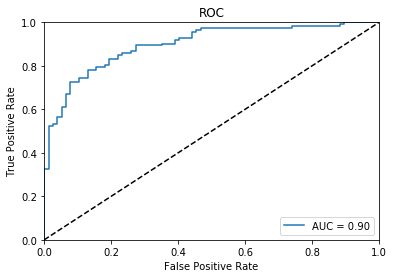

In [14]:
# Confusion Matrix
y_pred = clf_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### RF

In [16]:
#max_features = 23, sqrt(500)
clf_rf = RandomForestClassifier(n_estimators=1000, max_features=23)
clf_rf = clf_rf.fit(X_train, y_train)
print(cv.cross_val_score(clf_rf, X_train, y_train, cv=5).mean())

0.877004182642


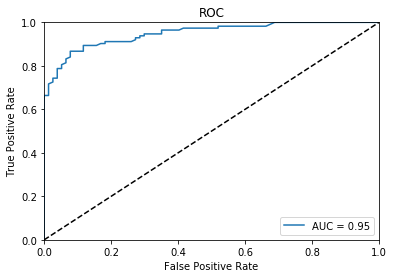

In [17]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_rf.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Get important features
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

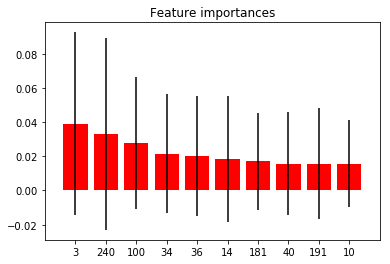

In [19]:
# Print the feature ranking

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(10), indices[:10])
plt.xlim([-1, 10])
plt.show()

In [20]:
importances[indices][:50]

array([ 0.03918539,  0.03297582,  0.02774971,  0.02162186,  0.02023726,
        0.01837336,  0.01696719,  0.01575641,  0.01556768,  0.01556015,
        0.01330352,  0.01228417,  0.01143092,  0.01028765,  0.0096745 ,
        0.00934765,  0.00858803,  0.00790245,  0.00743106,  0.00719739,
        0.00677387,  0.00676352,  0.00676168,  0.00673312,  0.00670942,
        0.00669805,  0.00656735,  0.00588814,  0.0058122 ,  0.00579686,
        0.00574066,  0.00558127,  0.00556788,  0.0051783 ,  0.00512273,
        0.00492222,  0.00415335,  0.00408624,  0.00402311,  0.00392482,
        0.00391488,  0.00384413,  0.00379674,  0.00378783,  0.00378319,
        0.003742  ,  0.0037276 ,  0.00368992,  0.00355425,  0.00352827])

In [ ]:
# save feature genes
tmp = pd.DataFrame(indices[:50])
tmp.to_csv('../data/RF_importance50.csv', index=True)

### xgb

In [21]:
clf_xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,  
                    subsample=0.5, colsample_bytree=0.5, seed=0)                  
clf_xgb = clf_xgb.fit(X_train, y_train)
print(cv.cross_val_score(clf_xgb, X_train, y_train, cv=5).mean())
print(cv.cross_val_score(clf_xgb, X_train, y_train, cv=5))

0.886258278146
[ 0.875       0.85430464  0.90066225  0.91390728  0.88741722]


In [92]:
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier


clf_xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,  
                    subsample=0.5, colsample_bytree=0.5, seed=0)                  
clf_xgb = clf_xgb.fit(X_train, y_train)
print(cross_val_score(clf_xgb, X_train, y_train, cv=5).mean())
print(cross_val_score(clf_xgb, X_train, y_train, cv=5))

0.8862582781456954
[0.875      0.85430464 0.90066225 0.91390728 0.88741722]


In [93]:
probas_ = clf_xgb.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

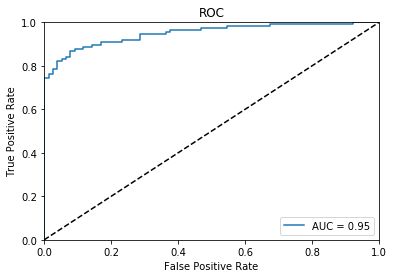

In [22]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_xgb.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [108]:
# OR interactive RUC with bokeh
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook

# output_file("ruc.html")
source = ColumnDataSource(data=dict(
    x=fpr,
    y=tpr,    
))
TOOLTIPS = [
    ("(x,y)", "($x, $y)"),    
]

output_notebook()
p = figure(plot_width=600, plot_height=400, tooltips=TOOLTIPS,)
p.line('x', 'y', line_width=2, source=source)
show(p)

Loading BokehJS ...

### model ensemble

In [23]:
from sklearn.ensemble import VotingClassifier

In [24]:
clf_vote = VotingClassifier(
    estimators=[
        ('svm', clf_svm),
        ('xgb', clf_xgb),
        ('RF', clf_rf),
        ],
    weights=[2,4,3],
    voting='soft')
clf_vote.fit(X_train,y_train)
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5).mean())
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5))

0.888915998606
[ 0.86842105  0.87417219  0.9205298   0.90066225  0.88741722]


In [25]:
print(cv.cross_val_score(clf_vote, X_train, y_train, cv=5, scoring= 'accuracy').mean())

0.890240501917


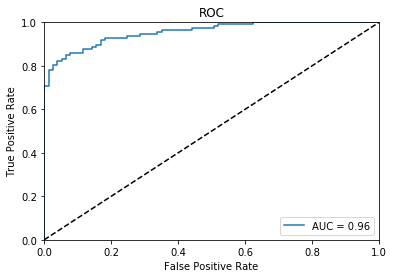

In [26]:
# Plot ROC curve
# Compute roc and auc
probas_ = clf_vote.predict_proba(X_test)
y_test[y_test == 2] = 0
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot roc curve
plt.clf()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### CNN

In [66]:
### keras
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [82]:
nb_epoch = 200 
batch_size = 30

In [81]:
arrayTrainFeatures = np.array(X_train)
arrayTrainLabels = np.array(y_train)
arrayTestFeatures = np.array(X_test)

In [83]:
cnnModel = Sequential()
cnnModel.add(Dense(1, input_dim=500, activation='sigmoid'))
cnnModel.add(Dense(1, input_dim=500, activation='sigmoid'))
cnnModel.add(Dense(1, input_dim=5, activation='sigmoid'))
cnnModel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [84]:
cnnModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1)                 501       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [85]:
cnnModel.fit(arrayTrainFeatures, arrayTrainLabels,
              validation_split=0.2,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              shuffle=True)

Train on 604 samples, validate on 152 samples
Epoch 1/200
604/604 [==============================] - 0s 731us/step - loss: 0.6788 - acc: 0.6093 - val_loss: 0.6821 - val_acc: 0.5789
Epoch 2/200
604/604 [==============================] - 0s 46us/step - loss: 0.6758 - acc: 0.6093 - val_loss: 0.6813 - val_acc: 0.5789
Epoch 3/200
604/604 [==============================] - 0s 57us/step - loss: 0.6743 - acc: 0.6093 - val_loss: 0.6805 - val_acc: 0.5789
Epoch 4/200
604/604 [==============================] - 0s 66us/step - loss: 0.6726 - acc: 0.6093 - val_loss: 0.6794 - val_acc: 0.5789
Epoch 5/200
604/604 [==============================] - 0s 77us/step - loss: 0.6708 - acc: 0.6093 - val_loss: 0.6785 - val_acc: 0.5789
Epoch 6/200
604/604 [==============================] - 0s 63us/step - loss: 0.6694 - acc: 0.6093 - val_loss: 0.6782 - val_acc: 0.5789
Epoch 7/200
604/604 [==============================] - 0s 61us/step - loss: 0.6677 - acc: 0.6093 - val_loss: 0.6783 - val_acc: 0.5789
Epoch 8/200
604

604/604 [==============================] - 0s 62us/step - loss: 0.4113 - acc: 0.9851 - val_loss: 0.5831 - val_acc: 0.7434
Epoch 122/200
604/604 [==============================] - 0s 52us/step - loss: 0.4081 - acc: 0.9851 - val_loss: 0.5865 - val_acc: 0.7500
Epoch 123/200
604/604 [==============================] - 0s 53us/step - loss: 0.4053 - acc: 0.9851 - val_loss: 0.5898 - val_acc: 0.7500
Epoch 124/200
604/604 [==============================] - 0s 61us/step - loss: 0.4023 - acc: 0.9851 - val_loss: 0.5890 - val_acc: 0.7500
Epoch 125/200
604/604 [==============================] - 0s 56us/step - loss: 0.3991 - acc: 0.9851 - val_loss: 0.5736 - val_acc: 0.7500
Epoch 126/200
604/604 [==============================] - 0s 58us/step - loss: 0.3961 - acc: 0.9851 - val_loss: 0.5785 - val_acc: 0.7237
Epoch 127/200
604/604 [==============================] - 0s 57us/step - loss: 0.3929 - acc: 0.9851 - val_loss: 0.5766 - val_acc: 0.7303
Epoch 128/200
604/604 [==============================] - 0s 54

In [86]:
cnnPred = np.round(cnnModel.predict(arrayTestFeatures))

### Conclusion
1. models reached average cross validation accuracy of 0.88 and AUC > 0.95, which is not bad for biological data with limited samples
2. diverse model ensemble with diverse models only slightly improved accuracy, perhaps because different models all picked same strong predictors hence adding different modele together did not improve performance
3. neural network is not a best perfomer in this case, perhaps more training data are needed